# Evolution equations

Define dimensionless $(x, y, j^x, j^y, {\cal P}, w, \tau)$ quantities such that
\begin{align}
M &= \alpha x\\
M_c &= \alpha y \\
J &= \beta j^x\\
J_c &= \beta j^y\\
P_{gw} &= \gamma {\cal P}\\
\omega &= w \mu\\
t &= \epsilon \tau\, .
\end{align}
We will make sure these are dimensionless by defining the dimensionful factors
\begin{align}
\alpha &= M_0 \\
\beta &= M_0 c^2 \mu^{-1} \\
\gamma &= M_0 c^2 \mu \\
\epsilon &= \mu^{-1}\, ,
\end{align}
and letting $\mu = \hbar/(m_b c^2)$ by the Compton frequency associated with the boson rest mass, $m_b$.
We will also let $M_0$ be the *initial* black-hole mass.
Note that then we have:
\begin{align}
a &= \frac{c j_x \epsilon}{x} \\
\chi &= \frac{j_x}{x^2} \frac{\epsilon}{T_0}\, ,
\end{align}
where we have defined the time $T_0 = G M_0/c^3$. And also the SR condition is saturated when
\begin{equation}
\left( \frac{2}{m} \frac{T_0}{\epsilon}\right)^2 = \frac{j_x}{x^2\left(mx-j_x\right)}
\end{equation}

With the above notation, the BHB evolution equations become:
\begin{align}
x' &= -2 w_I y\\
x' + y' &= -{\cal P}\\
(j^x)' &= -2 m w_I w_R^{-1} y\\
(j^x)' + (j^y)' &= -m w_R^{-1} {\cal P}
\end{align}
for $m$ the boson magnetic quantum number ($m=1$ for dominant scalar level), and where the prime denotes ${\rm d}/{\rm d}\tau$.
We may turn these into finite-difference equations to obtain:
\begin{align}
x_{i+1} &= x_i -2 w^I_i y_i \delta \tau \\
y_{i+1} &= y_i + 2 w^I_i y_i \delta\tau -{\cal P}_i \delta \tau\\
j^x_{i+1} &= j^x_i -2 m (w^I_i/ w^R_i) y_i \delta \tau\\
j^y_{i+1} &= j^y_i + m \left( 2 w^I_i y_i -  {\cal P}_i\right)\delta \tau / w^R_i
\end{align}
Thes can be evolved from $(x_0, y_0, j^x_0, j^y_0)$ until the SR spin threshold is reached.
The final state can then be converted into physical units using the scalings defined above.

In [161]:
import numpy as np
from matplotlib import pyplot as plt
from gwaxion import physics

In [321]:
def get_sr_cond(x, jx, T0, epsilon, m=1):
    return jx - x**2 * (m*x - jx) * 4*T0**2/(m*epsilon)**2


# define the solver
def evolve_bhb(bhb_0, y_0=1E-8, jy_0=1E-8, l=1, m=1, nr=0, dtau=None, max_steps=1E6, pgw=None, tolerance=1e-3):
    if not bhb_0.is_superradiant(m):
        raise ValueError("Initial BHB not superradiant for m = %i" % m)
    # initial mass
    M0 = bhb_0.bh.mass
    T0 = physics.G_SI*M0/physics.C_SI**3
    # time step
    epsilon = 1./bhb.boson.omega
    # other dimensionfull constants
    alpha = M0
    beta = epsilon*M0*physics.C_SI**2
    gamma = M0*physics.C_SI**2 / epsilon
    dtau = dtau or bhb_0.cloud(l, m, nr).growth_time/10.

    # GW power should be a function of current state
    # during the growth state, we can simply ignore it
    # if pgw is None:
    #    def pgw(*args, **kwargs):
    #         return 0.
        
    # initial state
    x_0 = 1
    jx_0 = bhb_0.bh.angular_momentum / beta  # same as alpha_0/2
    n = l + nr + 1
    wR_0 = bhb.level_omega_re(n) * epsilon
    wI_0 = bhb.level_omega_im(l, m, nr) * epsilon
    P_0 = 0  # pgw(bhb_0, y_0=1E-8, jy_0=1E-8, l=1, m=1, nr=0)
      
    # initialize arrays
    xs = [x_0]
    ys = [y_0]
    jxs = [jx_0]
    jys = [jy_0]
    inv_wRs = [1./wR_0]
    wIs = [wI_0]
    Ps = [P_0]
    time = [0]
    
    sr_conds = [get_sr_cond(x_0, jx_0, T0, epsilon, m=m)]
    
    # evolve
    for i in range(int(max_steps)):
        # update x & j
        dx = - 2*wIs[i]*ys[i]*dtau
        x_new = xs[i] + dx
        y_new = ys[i] - dx - Ps[i]*dtau
        # update jx & jy
        djx = -2*m*wIs[i]*inv_wRs[i]*ys[i]*dtau
        jx_new = jxs[i] + djx
        jy_new = jys[i] - djx - m*inv_wRs[i]*Ps[i]*dtau
        # update w's
        bh = physics.BlackHole(x_new*alpha, j=jx_new*beta)
        bhb_new = physics.BlackHoleBoson(bh, bhb_0.boson)
        inv_wR_new = 1./ (bhb_new.level_omega_re(n) * epsilon)
        wI_new = bhb_new.level_omega_im(l, m, nr) * epsilon
        # append
        xs.append(x_new)
        ys.append(y_new)
        jxs.append(jx_new)
        jys.append(jy_new)
        inv_wRs.append(inv_wR_new)
        wIs.append(wI_new)
        Ps.append(0)
        time.append(time[i] + dtau)
        # compute SR condition
        sr_cond = get_sr_cond(x_new, jx_new, T0, epsilon, m=m)
        sr_conds.append(sr_cond)
#         if (sr_conds[i] - sr_cond < tolerance*sr_cond) and (sr_cond < tolerance*sr_conds[0]):
#             break
#         #print x_new, jx_new, sr_cond, bhb_new.is_superradiant(m)
        frac_decrease = (sr_conds[i] - sr_cond)/float(sr_cond)
        change_ratio = float(sr_cond) / sr_conds[0]
        if frac_decrease < tolerance and (change_ratio < tolerance):
            break
        elif frac_decrease < 0.05:
            dtau *= 1.1
        elif frac_decrease > 0.05:
            dtau *= 0.9
        
    return bhb_new, tuple([np.array(l) for l in [xs, jxs, ys, jys, sr_conds, time]])

In [326]:
bhb = physics.BlackHoleBoson.from_parameters(m_bh=60, chi_bh=0.7, alpha=0.001, ev=True)

bhb_new, (xs, jxs, ys, jys, sr_conds, time) = evolve_bhb(bhb)
print bhb_new.bh.mass_msun, bhb_new.bh.chi

59.958239503483085 0.0039972000003478106


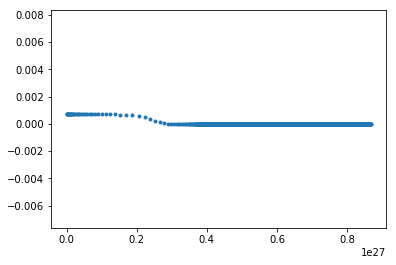

In [327]:
plt.figure()
plt.scatter(time, sr_conds, marker='.')
plt.show()

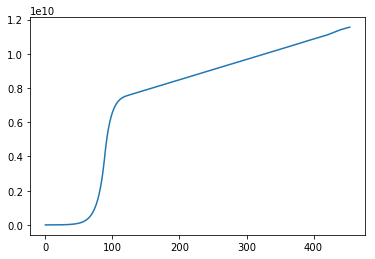

In [317]:
plt.figure()
plt.plot(time)
plt.show()

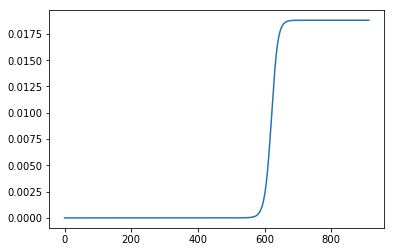

In [295]:
plt.figure()
plt.plot(ys/xs)
plt.show()

In [97]:
epsilon = 1./bhb.boson.omega
T0 = physics.G_SI*bhb.bh.mass/physics.C_SI**3

epsilon/T0

4.454458956955306

In [9]:
c = bhb.cloud(1,1,0)
c.growth_time

37586.92300815276

## Scipy

Try a less artisanal method using `scipy.sove_ivp`.

In [189]:
# # let Y = [x, y, jx]
# # I simplify things by letting Pgw = 0

# # first define the function dy/dt
# def fun(t, Y, bhb_0=None, l=1, m=1, nr=0):
#     x, y, jx = Y
#     # set scalings
#     epsilon = 1./bhb_0.boson.omega
#     alpha = bhb_0.bh.mass
#     beta = epsilon * bhb_0.bh.mass*physics.C_SI**2
#     # update bhb
#     bh = physics.BlackHole(x*alpha, j=jx*beta)
#     bhb_new = physics.BlackHoleBoson(bh, bhb_0.boson)
#     # obtain rates
#     inv_wR = 1./(bhb_new.level_omega_re(l+nr+1) * epsilon)
#     wI = bhb.level_omega_im(l, m, nr) * epsilon
#     # compute derivatives
#     dxdt = - 2*wI*y
#     dydt = - dxdt
#     djxdt = -2*m*wI*inv_wR*y
#     return [dxdt, dydt, djxdt]

Let's test this:

In [191]:
# # set initial state

# bhb_0 = physics.BlackHoleBoson.from_parameters(m_bh=60, chi_bh=0.7, alpha=0.176, ev=True)

# epsilon = 1./bhb_0.boson.omega
# alpha = bhb_0.bh.mass
# beta = epsilon * bhb_0.bh.mass*physics.C_SI**2

# x_0 = 1
# jx_0 = bhb_0.bh.a/(physics.C_SI*epsilon)
# y_0 =1

# T0 = physics.G_SI*M0/physics.C_SI**3
# sr_cond_0 = get_sr_cond(x_0, y_0 , T0, epsilon)

# # now define the stopping condition
# def get_sr_cond(x, jx, T0, epsilon, m=1):
#     return jx - x**2 * (m*x - jx) * 4*T0**2/(m*epsilon)**2

# def stopped_growth(t, Y, bhb_0=bhb_0, m=1, sr_cond_0=sr_cond_0, tolerance=1E-3):
#     x, y, jx = Y
#     # set scalings
#     T0 = physics.G_SI*bhb_0.bh.mass/physics.C_SI**3
#     epsilon = 1./bhb_0.boson.omega
#     # stop when SR condition no longer satisfied
#     sr_cond = get_sr_cond(x, jx, T0, epsilon, m=m)
#     return (sr_cond - sr_cond_0)/sr_cond_0 - tolerance

# stopped_growth.terminal = True
# stopped_growth.direction = -1

# # run solver

# from scipy.integrate import solve_ivp

# sol = solve_ivp(lambda t, Y: fun(t, Y, bhb_0=bhb_0), [0, 1000], [x_0, y_0, jx_0], events=stopped_growth)